In [17]:
#! python3.10 -m pip install numpy
#! python3.10 -m pip install matplotlib 
#! python3.10 -m pip install opencv-python

In [18]:
import json
import numpy as np
from queue import PriorityQueue
import codecs
import cv2
import matplotlib.pyplot as plt

In [19]:
class Street:
  def __init__(self, id, name):
    self.id = id
    self.name = name
    
class Point:
  def __init__(self, id, x, y, streetList: list):
    self.id = id
    self.x = x
    self.y = y
    self.streetList = streetList
  
  def getId(self) -> int:
    return self.id
  
  def getPosition(self) -> list:
    return [self.x, self.y]
  
  def getStreetList(self) -> list:
    return self.streetList

road_id = 0
class Road:
  def __init__(self , point1: Point, point2: Point, oneWayRoad):
    global road_id
    self.id = road_id
    road_id += 1
    self.point1 = point1
    self.point2 = point2
    self.oneWayRoad = oneWayRoad
  def getPoint1(self)->Point:
    return self.point1
  def getPoint2(self)->Point:
    return self.point2
  def getLength(self):
    if self.length != -1:
      x1, y1 = self.getPoint1().getPosition()
      x2, y2 = self.getPoint2().getPosition()
      self.length = ((x1-x2)**2+(y1-y2)**2)**(1/2)
    return abs()

class Graph:
  next_point_dict = {}
  def add_road(self, road_to_add: Road):
    p1Id = road_to_add.point1.getId()
    p2Id = road_to_add.point2.getId()
    if p1Id not in self.next_point_dict:
      self.next_point_dict[p1Id] = []
    if p2Id not in self.next_point_dict:
      self.next_point_dict[p2Id] = []
    if road_to_add.oneWayRoad!= 1:
      self.next_point_dict[p2Id] += [p1Id]
    if road_to_add.oneWayRoad!= -1:
      self.next_point_dict[p1Id] += [p2Id]
  def get_next_point_dict(self):
    return self.next_point_dict

In [20]:
scale_width_ratio = 0
scale_height_ratio = 0
x_max = 105.850260
y_max = 21.044922
x_min = 105.844521
y_min = 21.039959
streetDict = {}
pointDict = {}
roadDict = {}
graph = Graph()

In [21]:
def read_data_from_file():
    f = codecs.open("data.json", 'r', encoding='utf-8')
    fileContent = f.read()
    dataLoad = json.loads(fileContent)
    
    for street_id in dataLoad["street"]:
      newStreet = Street(street_id, dataLoad["street"][street_id])
      streetDict[street_id] = newStreet
    for point_id in dataLoad["point"]:
      tmpPoint = dataLoad["point"][point_id]
      newPoint = Point(int(point_id), tmpPoint["x"], tmpPoint["y"], tmpPoint["streetList"])
      pointDict[int(point_id)] = newPoint
    
    for road in dataLoad["road"]:
      newRoad = Road(pointDict[road["point1"]], pointDict[road["point2"]], road["oneWayRoad"])
      graph.add_road(newRoad)
read_data_from_file()

In [29]:
def pointTransform(position):
  x_temp, y_temp = position
  return [int((x_temp - x_min) * scale_width_ratio), 
          int((y_max - y_temp) * scale_height_ratio)]

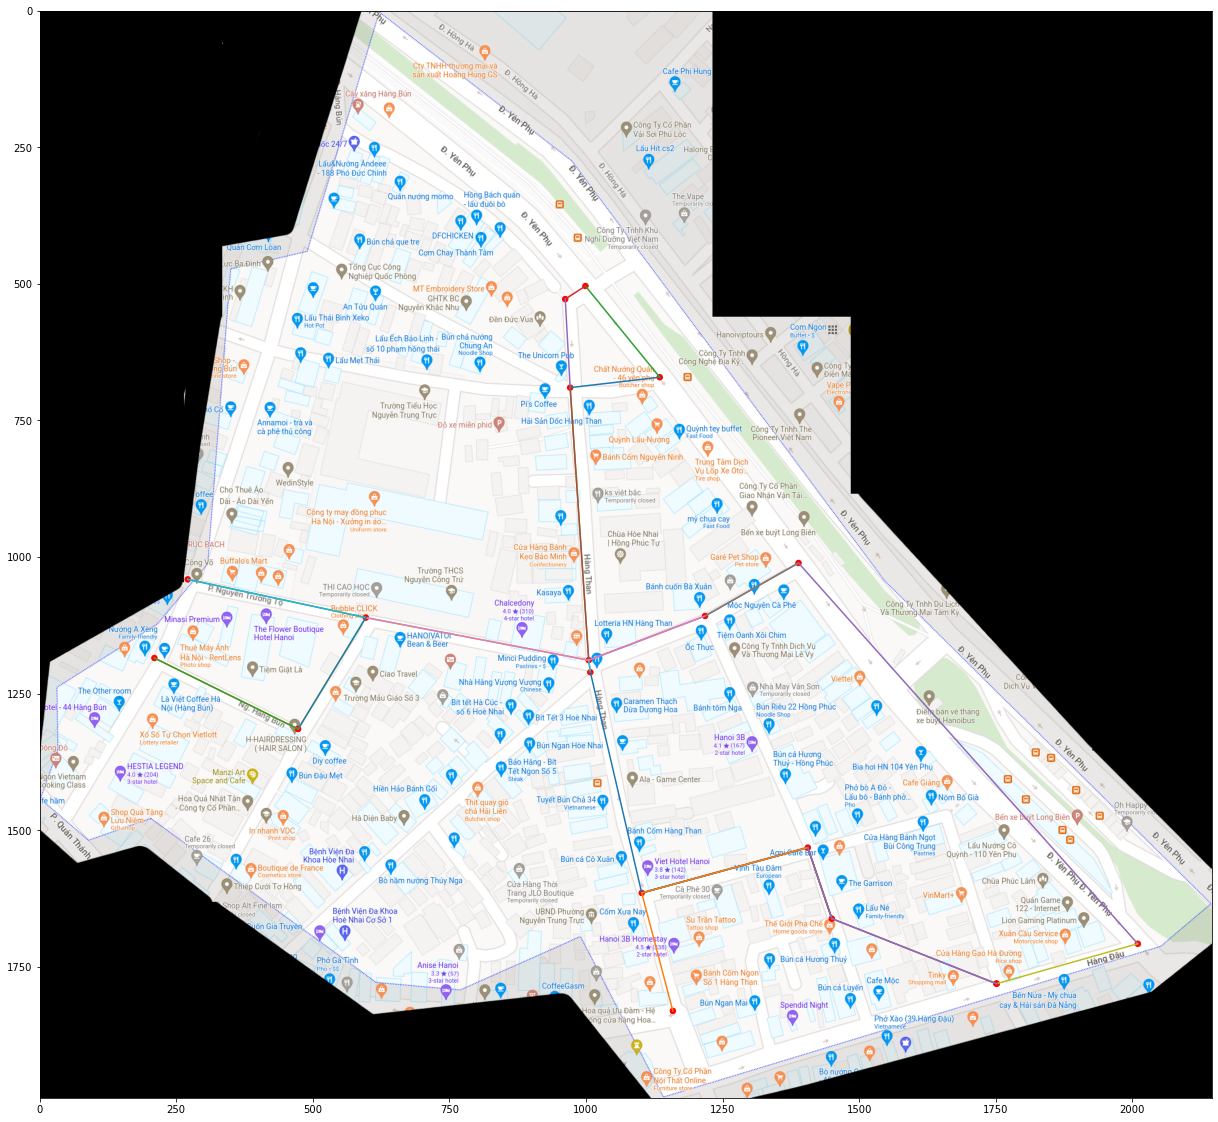

In [34]:
def read_image():
  global scale_width_ratio
  global scale_height_ratio
  fig, ax = plt.subplots(figsize=(21, 20))
  img = cv2.imread("./map.png")
  img_height, img_width, color_channel = img.shape
  ax.imshow(img)
  scale_width_ratio = img_width/(x_max-x_min)
  scale_height_ratio = img_height/(y_max-y_min)
  ax.set_xlim(0, img_width)
  ax.set_ylim(0, img_height)
  ax.invert_yaxis()
  for pnt in pointDict:
    x_temp, y_temp = pointDict[pnt].getPosition()
    x_temp, y_temp = pointTransform([x_temp, y_temp])
    ax.add_patch(plt.Circle((x_temp,y_temp),5, color='r'))
  
  nextP = graph.get_next_point_dict()
  for pointId in nextP:
    p1x, p1y = pointTransform(pointDict[pointId].getPosition())
    point2 = nextP[pointId]
    for pt2Id in point2:
      p2x, p2y = pointTransform(pointDict[pt2Id].getPosition())
      ax.plot([p1x, p2x], [p1y, p2y])    
  plt.show()
read_image()

In [24]:
def getNearestRoad(x, y)->Road:
  pass

def calculateLength(point1: Point, point2: Point):
  x1, y1 = point1.getPosition()
  x2, y2 = point2.getPosition()
  return ((x1-x2)**2+(y1-y2)**2)**(1/2)

In [25]:

def findPath(x_start, y_start, x_target, y_target):
  startRoad = getNearestRoad(x_start, y_start)
  targetRoad = getNearestRoad(x_target, y_target)
  visitedPoint = {}
  nextPointDict = graph.get_next_point_dict()
  pathPriorityQueue = PriorityQueue()
  pathPriorityQueue.put(
    ( calculateLength(startRoad.getPoint1(), 
                    Point(-1, x_start, y_start, [])),
      startRoad.getPoint1().getId()))
  pathPriorityQueue.put(
    ( calculateLength(startRoad.getPoint2(), 
                    Point(-1, x_start, y_start, [])),
      startRoad.getPoint2().getId()))
  while not pathPriorityQueue.empty():
    tempLength, tempPointId = pathPriorityQueue.get()
    if visitedPoint[tempPointId] == True:
      continue
    visitedPoint[tempPointId] = True
    for nextPointId in nextPointDict[tempPointId]:
      pathPriorityQueue.put(
        tempLength + calculateLength(
            pointDict[tempPointId], 
            pointDict[nextPointId]
          ),
        startRoad.getPoint2().getId()
      )


In [26]:
def getNearestRoad(x_start,y_start):
    distances = np.zeros(len(roadDict))
    for i in range(len(roadDict)):
        x1,y1 = roadDict[i].getPoint1().getPosition()
        x2,y2 = roadDict[i].getPoint2().getPosition()
        distance = np.abs((y2-y1)*x_start - (x2-x1)*y_start + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)
        distances[i] = distance
    nearest_line_index = np.argmin(distances)
    return roadDict[nearest_line_index]
getNearestRoad(1,1)